Using `SimPy` will simulate a simplified airport security system at a busy airport. The simulation follows the following distribution: Passengers arrive according to a Poisson distribution with $\lambda_{1}$ = 50 per minute (i.e., mean interarrival rate $\mu_{1}$ = 0.2 minutes) to the ID/boarding-pass check queue, where there are several servers who each have exponential service time with mean rate $\mu_{2}$ = 0.75 minutes. [Hint: model them as one block that has more than one resource.] After that, the passengers are assigned to the shortest of the several personal-check queues, where they go through the personal scanner (time is uniformly distributed between 0.5 minutes and 1 minute).

## Brainstorming a Simulation Algorithm
Before we write out a single line of code, we need to figure out the process of how to simulate this security system.[^1] 

Since we're trying to simulate it, we need to realistically model this process, so that it's an accurate reflection of what passengers at a busy airport really experience. These are the steps a passenger might take at the airport:

1.   **Arrive** at the airport ($X$~Pois $(5)$; $E(X)=0.2$) 

2.   **Checkpoint** with security agent, whose service time is distributed ~ Exp $(1/0.75)$

3.   **Screen** through a body scanner, whose scanning time is uniformly distributed ~ Unif $(0.5, 1)$

The prompt allows us to control several parts of the simulation. It says that we can vary the number of checkers and scanning queues available to determine how many are needed to keep average wait times below 15 minutes. We can also change the number of arrivals from 5 to 50 to simulate a busier airport. Let's just try 5 for now and change when we know our simulation works well for 5. 

[^1]: I got a lot of help from this [link](https://realpython.com/simpy-simulating-with-python/#what-simulation-is).

## Setting Up the Environment
Before we start building our simulation, we'll load in the libraries we'll be using.

In [1]:
%reset
import sys
print(f"=== Python version ===\n{sys.version}\n")
import simpy
import random
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import cm
from IPython.display import display, Markdown

=== Python version ===
3.10.6 (v3.10.6:9c7b4bd164, Aug  1 2022, 17:13:48) [Clang 13.0.0 (clang-1300.0.29.30)]



## Creating the Airport Class
The really nice thing about Python, and other object-oriented, programming languages, is that we can write programs in a way that mirrors or reflects the way we think about the real world. Naturally, we use object-oriented programming to conduct our simulation. 

We can define what variables should be specified for that object. For example, if we were to create a `Person` object, we can imagine this object containing a variety of variables, like their name, height, age, etc. In the same way, when we define our `Airport` object, we can assign to this object different variables as well. Now that we've outlined our algorithm, we can create an airport class with specific characteristics that will serve as the blueprint for our security system simulation. 

We'll create our `Airport` object with two simple methods that we outlined earlier: the checkpoints and the scanners. We don't know how many checkers and scanners are available at the simulated airport; in fact, that's the problem we're trying to solve: how many checkers and scanners do we need to keep the average wait time under 15 minutes? 

We'll declare our variables, `num_checkers` and `num_scanners`. We'll figure out how many we'll need later; but for now, we just need to know that they're both integral parts of the Airport class. Since we know that it takes an exponentially-distributed expected rate of $0.75$ for a checker to check IDs, and the expectation of the scan rate is $\frac{1}{\lambda}$, then $\lambda_{checker} = \frac{1}{0.75}$. `env.timeout()` tells `simpy` to trigger an event after a certain amount of time has passed. In this case, the event is that a passenger's ID was checked. 

Since the passenger is the one getting checked, we pass in `pax` as a required argument. Finally, after passengers proceed beyond the checkpoint, they will get scanned, which will take anywhere between 0.5min to 1 min, where each possible moment within that time frame is equally likely. Now that we've outlined the Airport class, let's code it. 

In [2]:
# create our class object with the following methods 
class Airport:
        
    def __init__(self, env, num_checkers, num_scanners):
        # the input env will be a simpy environment
        self.env = env
        # the simpy.Resource is a finite resource:
        # using one of them will take time and only so many are available at once, just like a real environment
        self.checkers = simpy.Resource(env, num_checkers)
        self.scanners = simpy.Resource(env, num_scanners)
    
    def checkpoint(self, pax):
        yield self.env.timeout(random.expovariate(1/0.75))

    def scan(self, pax):
        yield self.env.timeout(random.uniform(0.5, 1))
    


## Simulating the Airport Security System
Our goal, again, is to find the optimal number of resources (checkers and scanners) that gives an average wait time of less than 15 minutes. So first, we'll declare an empty list to store waiting times. 

### Moving through Security
Having set up the Airport class, we now introduce a rather important piece of the blueprint: the passenger! When the passenger arrives at the airport, they'll go through the rigorous security process, moving from check-in to getting scanned. We'll create a function that outlines this process. 

One other thing to note: `yield` is used to pause the execution of the function and release control back to the SimPy simulation environment. The `go_to_airport` function is a generator function, and `yield` statements are used to represent points in the simulation process where the passenger (`pax`) must wait for certain resources to become available.

In [3]:
def go_to_airport(env, pax, airport):
    # pax arrives at the airport
    # arrival holds the time at which each pax arrives at the airport
    arrival = env.now
    # since an airport checker is a shared resource, many passengers will encounter the same checker
    # but the checker can only help one person at a time, so we'll need to include some waiting behavior
        
    with airport.checkers.request() as check_request:
        # the pax generates a request to be checked
        yield check_request
        # then the pax waits for the checker to be available if the rest are unavailable
        yield env.process(airport.checkpoint(pax))
        # once the checker is done checking the previous pax, the current pax is checked
    
    with airport.scanners.request() as scan_request:
        yield scan_request
        yield env.process(airport.scan(pax))

    # we calculate the length of time it took for a pax to go through security
    wait_times.append(env.now-arrival)    

### Running the Simulation
Our next step is to define a function that will run the simulation. `run_simulation()` will be responsible for creating an instance of an airport and generating passengers until the simulation stops. The first thing that this function will do is create an instance of an airport. Since this is our object, we'll need to pass in all of the unknowns we've declared so far:

- `num_checkers`

- `num_scanners`

We'll start our simulation with 500 passengers in the airport, but then the rest of the passengers will trickle into the airport at ~ Pois(50) to mimic a busy airport. A first course in statistics reminds us that, if arrivals are Poisson, with arrival rate $\lambda$, then the time between arrivals, known as the inter-arrival time, follows the Exponential distribution, with $\frac{1}{\lambda}$ as the average inter-arrival time. So we set our `env.timeout()` to `random.expovariate(1/50)` if we don't want to use `np.random.poisson()`. When we call this function, the simulation will generate 500 passengers to start and begin moving them through security with `go_to_airport()`. New passengers will arrive at ~Pois(50) arrival rate and move through security in their own time.

In [4]:
def run_simulation(env, num_checkers, num_scanners):
    airport = Airport(env, num_checkers, num_scanners)
    for pax in range(500):
        env.process(go_to_airport(env, pax, airport))
    while True:
        # we wait 
        yield env.timeout(random.expovariate(1/50))
        # then we increment each passenger
        pax += 1 
        # then we generate the next person
        env.process(go_to_airport(env, pax, airport))

### Optimizing the Number of Resources
Now that we've created our simulation function, we need to run it through to determine where bottlenecks occur and figure out the minimum number of scanners and checkers we need such that average wait times are 15 minutes and under. To do this, we perform a double for-loop and pass in each value into our simulation function outlined below. Then we store the average wait times into a list and generate a Dataframe using this list. We'll let the simulation run for a simulated week's time.

In [5]:
random.seed(42)
result_list = []
for checkers in range(1, 51):
    for scanners in range(1, 51):
        results = pd.DataFrame()
        wait_times = []
        env = simpy.Environment()
        env.process(run_simulation(env, checkers, scanners))
        env.run(until=60*24*7)
        avg_wait = statistics.mean(wait_times)
        result_list.append([checkers, scanners, avg_wait])
results = pd.DataFrame(result_list, columns=['Checkers', 'Scanners', 'Avg Wait Times'])
display(results)


,Checkers,Scanners,Avg Wait Times
0,1,1,144.254469
1,1,2,145.704271
2,1,3,130.868324
3,1,4,126.861314
4,1,5,140.284792
...,...,...,...
2495,50,46,3.854616
2496,50,47,3.810900
2497,50,48,3.781251
2498,50,49,3.856013


Looking at the first and last four rows, it's very clear, not to mention obvious, that the bottleneck begins immediately with 1 checker and 1 scanner. Although given that there are 500 people in the airport and subsequent passengers interarriving at ~ Exp $(\frac{1}{50})$, an average 144-minute waiting time isn't actually that bad. I thought it'd be worse, but it's comparable to waiting in line for a ride at Disneyland. On the other hand, as our checking and scanning resources increased, the average waiting times naturally decreased. Let's create a surface plot to see where the bottleneck visually begins to happen. 

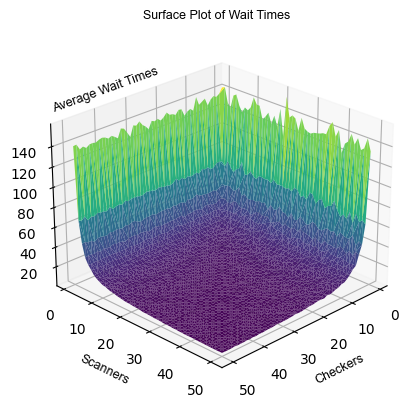

In [6]:
fig1 = plt.figure()
font = {'family': 'Arial', 'color': 'black', 'weight': 'normal', 'size': 9}
surf_plot = fig1.add_subplot(111, projection='3d')
x = results['Checkers']
y = results['Scanners']
z = results['Avg Wait Times']
surf_plot.plot_trisurf(x, y, z, cmap='viridis')
surf_plot.set_xlabel('Checkers', fontdict=font)
surf_plot.set_ylabel('Scanners', fontdict=font)
surf_plot.text2D(0.05, 0.77, 'Average Wait Times', transform=surf_plot.transAxes, rotation=20, fontdict=font)
plt.title('Surface Plot of Wait Times', fontdict=font)
surf_plot.grid()
surf_plot.view_init(elev=25, azim=45)
plt.show()

We observe that when we have all resources available, the wait time is below 20 minutes on the z-axis (marked out in the purple area). However, as our resources decrease, the colors begin to change, denoting the rise in average waiting times. On the opposite corner, we see this rise dramatically as the colors change from purple to green. When there are more checkers than scanners, or vice versa, long wait times are still abated, but when scanners and checkers are in short supply, average wait times dramatically increase in a rather steep fashion. 

So let's filter down our wait times and see what our minimum number of resources are required to keep average wait times below 15 minutes. 

In [7]:
filtered = results[results['Avg Wait Times'] <= 15.0]
display(filtered.head(10))

,Checkers,Scanners,Avg Wait Times
417,9,18,14.765074
427,9,28,14.953870
433,9,34,14.720481
434,9,35,14.592450
440,9,41,13.744306
447,9,48,14.935522
449,9,50,14.972662
461,10,12,14.703955
462,10,13,13.583199
464,10,15,13.866249


After filtering down our results, we now get a minimum threshold amount of checkers and scanners. If we increase the number of scanners, we can maintain the same amount of checkers and vice versa. Let's see how this plots now. 

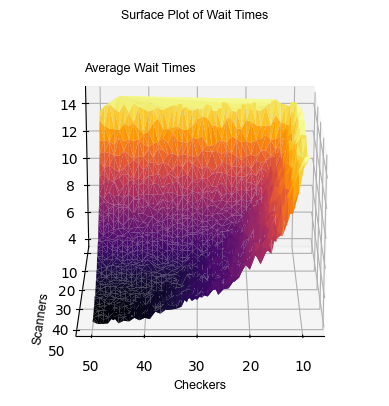

In [8]:
fig2 = plt.figure()
font = {'family': 'Arial', 'color': 'black', 'weight': 'normal', 'size': 9}
surf_plot2 = fig2.add_subplot(111, projection='3d')
x_filt = filtered['Checkers']
y_filt = filtered['Scanners']
z_filt = filtered['Avg Wait Times']
surf_plot2.plot_trisurf(x_filt, y_filt, z_filt, cmap='inferno')
surf_plot2.set_xlabel('Checkers', fontdict=font)
surf_plot2.set_ylabel('Scanners', fontdict=font)
surf_plot2.text2D(.2, 0.88, 'Average Wait Times', transform=surf_plot2.transAxes, rotation=0, fontdict=font)
plt.title('Surface Plot of Wait Times', fontdict=font)
surf_plot2.grid()
surf_plot2.view_init(elev=20, azim=90)
plt.show()

As usual, our plot reveals that the more we increase our resources, the less wait time there is. Finally, let's observe the behavior of the bottleneck: on a very busy day at an under-staffed airport, how quickly do wait times increase?

In [9]:
bottleneck = results[results['Avg Wait Times'] > 15.0].sort_values(by='Avg Wait Times', ascending=True)
display(bottleneck.tail(20))

,Checkers,Scanners,Avg Wait Times
4,1,5,140.284792
2450,50,1,140.569988
1700,35,1,140.591778
1400,29,1,140.812185
2400,49,1,140.911574
24,1,25,142.336038
5,1,6,142.521586
27,1,28,143.257469
45,1,46,143.701897
450,10,1,144.136880


Plotting this we get:

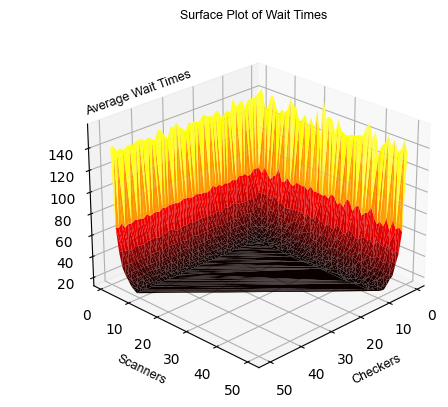

In [10]:
fig3 = plt.figure()
font = {'family': 'Arial', 'color': 'black', 'weight': 'normal', 'size': 9}
surf_plot3 = fig3.add_subplot(111, projection='3d')
x_bottle = bottleneck['Checkers']
y_bottle = bottleneck['Scanners']
z_bottle = bottleneck['Avg Wait Times']
surf_plot3.plot_trisurf(x_bottle, y_bottle, z_bottle, cmap='hot')
surf_plot3.set_xlabel('Checkers', fontdict=font)
surf_plot3.set_ylabel('Scanners', fontdict=font)
surf_plot3.text2D(-0.16, 0.65, 'Average Wait Times', transform=surf_plot.transAxes, rotation=20, fontdict=font)
plt.title('Surface Plot of Wait Times', fontdict=font)
surf_plot3.grid()
surf_plot3.view_init(elev=25, azim=45)
plt.show()

Since we want to know the number of resources that cause 15 minutes or greater average wait times, our plot cuts off the number of scanners and checkers diagonally. The average wait time increases dramatically as resources become unavailable. 

## Conclusion
Our results reveal this important observation: the number of resources at our disposal doesn't guarantee seamless operations if these resources aren't distributed in balance-ish. Even with a surplus of one resource, a bottleneck is determined by the slower of the two processes. If one of these processes is significant slower than the other, it will limit the overal throughput of the system. The pace at which a checker can verify IDs and boarding passes may be lightning fast, but if the scanners can't keep up, it invariably results in passenger delays. Conversely, if the scanners outnumber the checkers, the imbalance can create the same bottleneck, where passengers are forced to wait, frustrated by a seemingly endless queue. This phenomenon might seem counterintuitive at first, but it underscores a fundamental principle of optimization.

The time a passenger spends navigating the security checkpoint hinges on the duration of the slower of the two processes. This phenomenon can be likened to an infinity norm, where the maximum impact on the system's performance is determined by the 'worst-case' scenario. This intricate interplay of resources and processes exemplifies the critical nature of balance optimizing system performance.